In [1]:
# 警告(warning)の非表示化
import warnings
warnings.filterwarnings('ignore')

# 4章 顧客の全体像を把握する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章で顧客の全体像を把握しました。  
ここからは、機械学習を用いて顧客のグループ化や顧客の利用予測行なっていきましょう。  
ここでは、教師なし学習、教師あり学習の回帰を取り扱います。

### ノック31：データを読み込んで確認しよう

In [2]:
import pandas as pd
uselog = pd.read_csv('use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [3]:
uselog.head()

,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [5]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [6]:
customer.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


### ノック32：クラスタリングで顧客をグループ化しよう

In [7]:
customer_clustering = customer[["mean", "median","max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


k-meansクラスタリング  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

StandardScaler  
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[3 1 0 2]


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,3
1,5.083333,5.0,7,3,47,3
2,4.583333,5.0,6,3,47,3
3,4.833333,4.5,7,2,47,3
4,3.916667,4.0,6,1,47,3


### ノック33：クラスタリング結果を分析しよう

In [10]:
customer_clustering.columns = ["月内平均値","月内中央値", "月内最大値", "月内最小値","会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,1336,1336,1336,1336,1336
1,761,761,761,761,761
2,846,846,846,846,846
3,1249,1249,1249,1249,1249


In [11]:
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,5.522518,5.373129,8.743263,2.686377,14.831587
1,3.051243,2.885677,4.750329,1.653088,9.269382
2,8.054608,8.039598,10.009456,6.160757,7.072104
3,4.677494,4.671337,7.232986,2.153723,36.915933


### ノック34：クラスタリング結果を可視化してみよう

In [12]:
from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

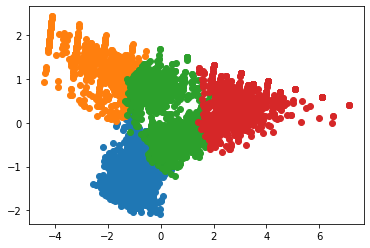

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

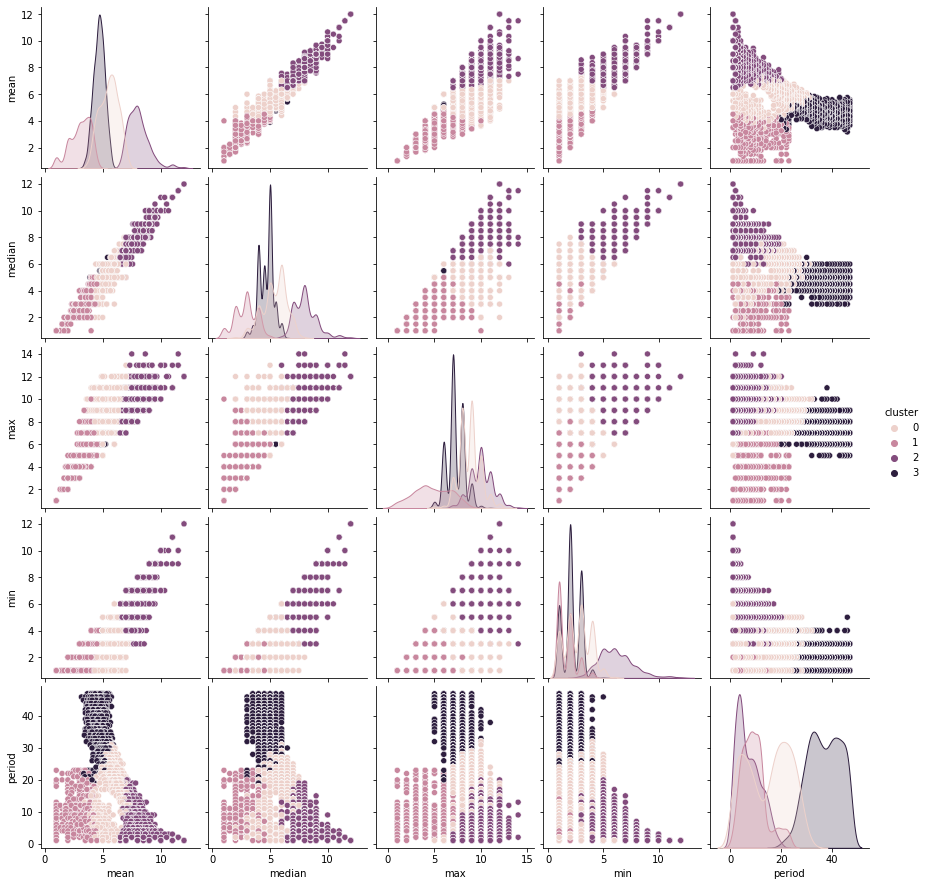

In [20]:
import seaborn as sns
customer_clustering.columns = ["mean","median", "max", "min","period", "cluster"]
sns.pairplot(pd.DataFrame(customer_clustering), hue="cluster", size=2.5)
customer_clustering.columns = ["月内平均値","月内中央値", "月内最大値", "月内最小値","会員期間", "cluster"]

### ノック35：クラスタリング結果をもとに退会顧客の傾向を把握しよう

In [21]:
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster","is_deleted"],as_index=False).count()[["cluster","is_deleted","customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,785
1,0,1,551
2,1,1,761
3,2,0,827
4,2,1,19
5,3,0,1230
6,3,1,19


In [27]:
customer_clustering[(customer_clustering['cluster']==1) & (customer_clustering['is_deleted']==0)]

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,cluster,customer_id,name,class,gender,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period


In [22]:
customer_clustering.groupby(["cluster","routine_flg"],as_index=False).count()[["cluster","routine_flg","customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,229
1,0,1,1107
2,1,0,496
3,1,1,265
4,2,0,52
5,2,1,794
6,3,0,2
7,3,1,1247


### ノック36：翌月の利用回数予測を行うためのデータ準備をしよう

In [31]:
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"],as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [34]:
year_months = list(uselog_months["年月"].unique())
print(year_months)
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data

['201804', '201805', '201806', '201807', '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903']


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
...,...,...,...,...,...,...,...,...,...
18305,201903,TS995853,8,11.0,NaN,NaN,NaN,NaN,NaN
18306,201903,TS998593,8,7.0,8.0,7.0,9.0,9.0,9.0
18307,201903,TS999079,3,2.0,6.0,9.0,6.0,6.0,4.0
18308,201903,TS999231,6,6.0,3.0,8.0,5.0,5.0,4.0


In [35]:
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


### ノック37：特徴となる変数を付与しよう

In [36]:
predict_data = pd.merge(predict_data, customer[["customer_id","start_date"]], on="customer_id", how="left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [37]:
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])
from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


### ノック38：来月の利用回数予測モデルを作成しよう

In [38]:
predict_data = predict_data.loc[predict_data["start_date"]>=pd.to_datetime("20180401")]
from sklearn import linear_model
import sklearn.model_selection
model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y)
model.fit(X_train, y_train)

LinearRegression()

In [39]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.614845157586942
0.5841018030000781


### ノック39：モデルに寄与している変数を確認しよう

In [40]:
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.336117
1,count_1,0.213225
2,count_2,0.181342
3,count_3,0.164675
4,count_4,0.064295
5,count_5,0.046306
6,period,0.052884


### ノック40：来月の利用回数を予測しよう

In [41]:
x1 = [3, 4, 4, 6, 8, 7, 8]
x2 = [2, 2, 3, 3, 4, 6, 8]
x_pred = [x1, x2]

In [42]:
model.predict(x_pred)

array([3.73518313, 1.9937631 ])

In [43]:
uselog_months.to_csv("use_log_months.csv",index=False)